In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla
from target import GMM_target, GMM_target2, Funnel
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target(args)

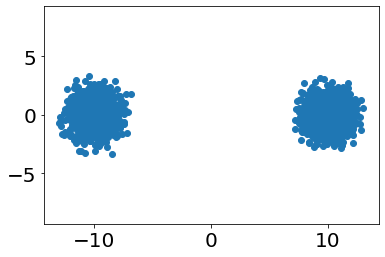

In [4]:
target_samples = target.get_samples(n=3000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 10000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  0%|          | 30/10000 [00:00<00:33, 294.93it/s]

Now we are running warmup!


  2%|▏         | 23/1000 [00:00<00:04, 228.23it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:03<00:00, 293.27it/s]


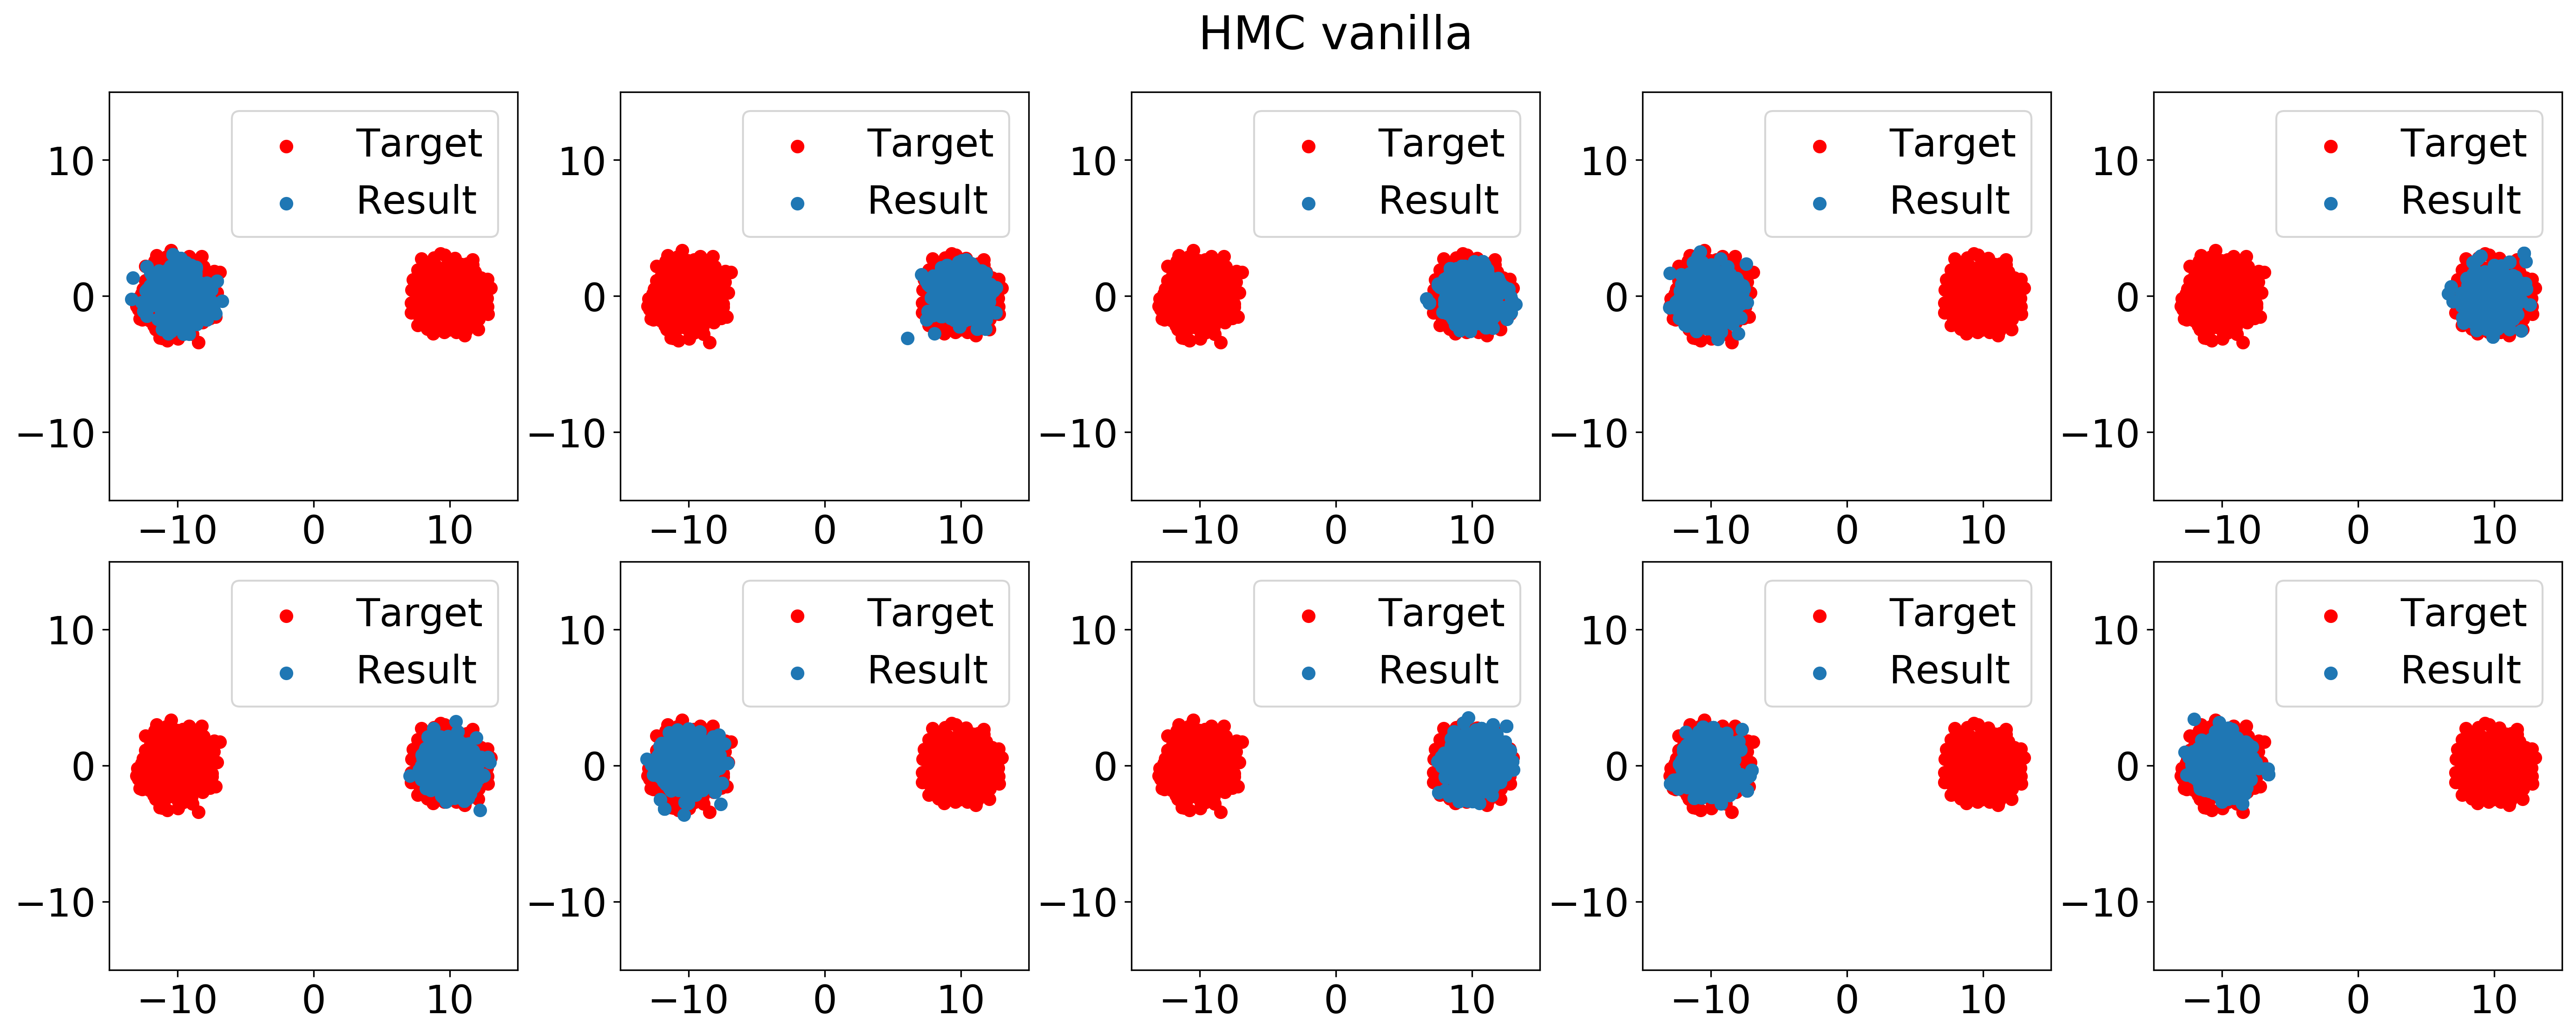

In [9]:
limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [10]:
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])

optimizer = torch.optim.Adam(params=transitions.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200)

##### Training

  0%|          | 0/10000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.06 and for +1: 0.94
Step size for 0-th transition is 0.5
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.54 and for +1: 0.46
Step size for 1-th transition is 0.5
Alpha (ref) for 1-th transition is 0.5


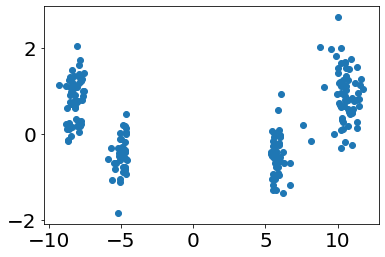

  0%|          | 2/10000 [00:00<10:46, 15.45it/s]

Current lr:  0.1
On batch number 0 ELBO is -15.845165252685547
On batch number 0 Best ELBO is -inf


  1%|          | 97/10000 [00:01<02:29, 66.19it/s]

On batch number 100 and on k = 1 we have for 0: 0.545 and for +1: 0.455
Step size for 0-th transition is 0.10040033608675003
Alpha (ref) for 0-th transition is 0.0001137901926995255
On batch number 100 and on k = 2 we have for 0: 0.07 and for +1: 0.93
Step size for 1-th transition is 0.5794577598571777
Alpha (ref) for 1-th transition is 0.03185448795557022


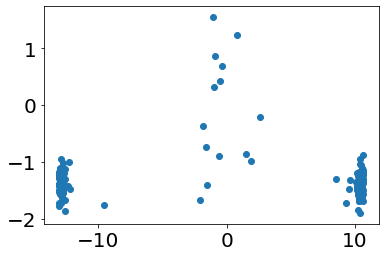

  1%|          | 105/10000 [00:01<02:59, 55.12it/s]

Current lr:  0.1
On batch number 100 ELBO is -64.06460571289062
On batch number 100 Best ELBO is -15.845165252685547


  2%|▏         | 191/10000 [00:02<02:02, 79.77it/s]

On batch number 200 and on k = 1 we have for 0: 0.505 and for +1: 0.495
Step size for 0-th transition is 0.08545579016208649
Alpha (ref) for 0-th transition is 3.3600482396423104e-09
On batch number 200 and on k = 2 we have for 0: 0.085 and for +1: 0.915
Step size for 1-th transition is 0.4860977828502655
Alpha (ref) for 1-th transition is 6.06938119744882e-05


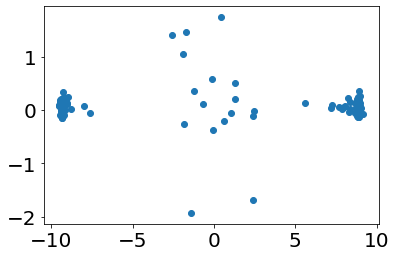

  2%|▏         | 201/10000 [00:02<02:18, 70.54it/s]

Current lr:  0.1
On batch number 200 ELBO is -97.34762573242188
On batch number 200 Best ELBO is -15.845165252685547


  3%|▎         | 294/10000 [00:04<02:39, 60.78it/s]

On batch number 300 and on k = 1 we have for 0: 0.49 and for +1: 0.51
Step size for 0-th transition is 0.08892013877630234
Alpha (ref) for 0-th transition is 1.003421123968451e-09
On batch number 300 and on k = 2 we have for 0: 0.065 and for +1: 0.935
Step size for 1-th transition is 0.517206609249115
Alpha (ref) for 1-th transition is 2.5437690055696294e-05


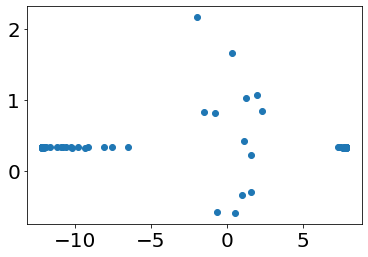

  3%|▎         | 301/10000 [00:04<03:25, 47.30it/s]

Current lr:  0.010000000000000002
On batch number 300 ELBO is -103.80388641357422
On batch number 300 Best ELBO is -15.845165252685547


  4%|▍         | 400/10000 [00:05<02:30, 63.68it/s]

On batch number 400 and on k = 1 we have for 0: 0.5 and for +1: 0.5
Step size for 0-th transition is 0.08621484786272049
Alpha (ref) for 0-th transition is 3.634739731417369e-10
On batch number 400 and on k = 2 we have for 0: 0.055 and for +1: 0.945
Step size for 1-th transition is 0.5464944243431091
Alpha (ref) for 1-th transition is 1.1387191989342682e-05


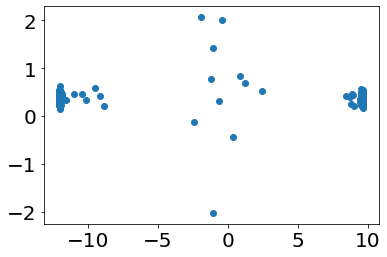

  4%|▍         | 407/10000 [00:05<03:06, 51.47it/s]

Current lr:  0.010000000000000002
On batch number 400 ELBO is -105.08477783203125
On batch number 400 Best ELBO is -15.845165252685547


  5%|▍         | 498/10000 [00:07<02:35, 60.95it/s]

On batch number 500 and on k = 1 we have for 0: 0.44 and for +1: 0.56
Step size for 0-th transition is 0.08727072179317474
Alpha (ref) for 0-th transition is 3.1964578206533645e-10
On batch number 500 and on k = 2 we have for 0: 0.08 and for +1: 0.92
Step size for 1-th transition is 0.5516002178192139
Alpha (ref) for 1-th transition is 1.0234289220534265e-05


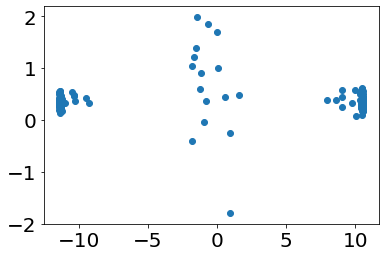

  5%|▌         | 505/10000 [00:07<03:01, 52.31it/s]

Current lr:  0.0010000000000000002
On batch number 500 ELBO is -104.8065414428711
On batch number 500 Best ELBO is -15.845165252685547


  6%|▌         | 592/10000 [00:08<01:47, 87.27it/s]

On batch number 600 and on k = 1 we have for 0: 0.49 and for +1: 0.51
Step size for 0-th transition is 0.08643946051597595
Alpha (ref) for 0-th transition is 2.8897700898866674e-10
On batch number 600 and on k = 2 we have for 0: 0.04 and for +1: 0.96
Step size for 1-th transition is 0.5491421222686768
Alpha (ref) for 1-th transition is 9.378827598993666e-06


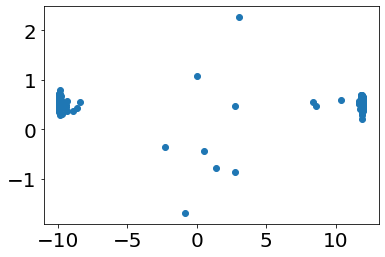

  6%|▌         | 609/10000 [00:08<02:05, 75.06it/s]

Current lr:  0.0010000000000000002
On batch number 600 ELBO is -105.062744140625
On batch number 600 Best ELBO is -15.845165252685547


  7%|▋         | 693/10000 [00:09<02:12, 70.25it/s]

On batch number 700 and on k = 1 we have for 0: 0.465 and for +1: 0.535
Step size for 0-th transition is 0.08650992065668106
Alpha (ref) for 0-th transition is 2.850356339845206e-10
On batch number 700 and on k = 2 we have for 0: 0.055 and for +1: 0.945
Step size for 1-th transition is 0.5495838522911072
Alpha (ref) for 1-th transition is 9.265761946153361e-06


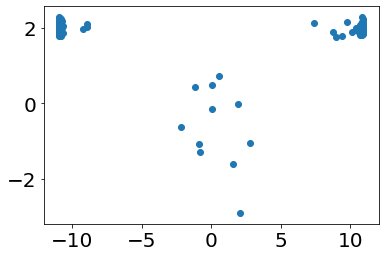

  7%|▋         | 711/10000 [00:10<02:27, 62.79it/s]

Current lr:  0.00010000000000000003
On batch number 700 ELBO is -106.97003936767578
On batch number 700 Best ELBO is -15.845165252685547


  8%|▊         | 796/10000 [00:11<02:33, 60.07it/s]

On batch number 800 and on k = 1 we have for 0: 0.465 and for +1: 0.535
Step size for 0-th transition is 0.08642379194498062
Alpha (ref) for 0-th transition is 2.8216873282360666e-10
On batch number 800 and on k = 2 we have for 0: 0.045 and for +1: 0.955
Step size for 1-th transition is 0.5491526126861572
Alpha (ref) for 1-th transition is 9.181739187624771e-06


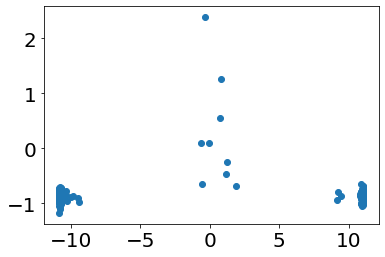

  8%|▊         | 803/10000 [00:11<03:01, 50.61it/s]

Current lr:  0.00010000000000000003
On batch number 800 ELBO is -106.04212188720703
On batch number 800 Best ELBO is -15.845165252685547


  9%|▉         | 896/10000 [00:13<02:06, 71.99it/s]

On batch number 900 and on k = 1 we have for 0: 0.51 and for +1: 0.49
Step size for 0-th transition is 0.0864231139421463
Alpha (ref) for 0-th transition is 2.8177074562485416e-10
On batch number 900 and on k = 2 we have for 0: 0.065 and for +1: 0.935
Step size for 1-th transition is 0.5491573810577393
Alpha (ref) for 1-th transition is 9.16922635951778e-06


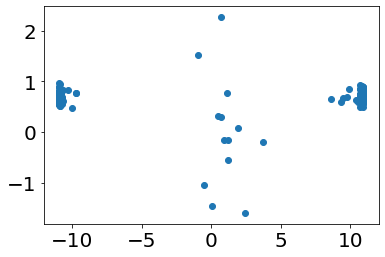

  9%|▉         | 904/10000 [00:13<02:39, 57.02it/s]

Current lr:  1.0000000000000004e-05
On batch number 900 ELBO is -104.66029357910156
On batch number 900 Best ELBO is -15.845165252685547


 10%|▉         | 991/10000 [00:14<01:41, 88.62it/s]

On batch number 1000 and on k = 1 we have for 0: 0.53 and for +1: 0.47
Step size for 0-th transition is 0.08641302585601807
Alpha (ref) for 0-th transition is 2.8150218267519733e-10
On batch number 1000 and on k = 2 we have for 0: 0.045 and for +1: 0.955
Step size for 1-th transition is 0.5491409301757812
Alpha (ref) for 1-th transition is 9.160486115433741e-06


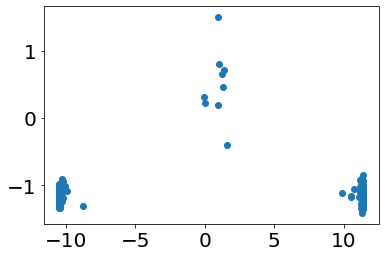

 10%|▉         | 991/10000 [00:14<02:11, 68.44it/s]

Current lr:  1.0000000000000004e-05
On batch number 1000 ELBO is -105.92816162109375
On batch number 1000 Best ELBO is -15.845165252685547
Early stopping on 1000


In [11]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = 15
y_lim = 5

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac):
#     pdb.set_trace()
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_r = -args.K * torch_log_2
    ## Loss version 1
#     log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
#     elbo_full = log_p + log_r - log_m
#     grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    ## Loss version 2
    log_m_tilde = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian
    log_m = log_m_tilde + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(log_m_tilde + sum_log_alpha * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), grad_elbo

if args.step_conditioning == 'fixed':
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            print('Step size for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].gamma_logit.detach())))
            print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
#                 ax[kk].set_xlim((-x_lim, x_lim))
#                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
#         plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [12]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [ ]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        q_new, p_new, _, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                   k=cond_vectors[k])
iterator.close()
    
samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        q_new, p_new, _, _, a, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                       k=cond_vectors[k])
        samples_our[i] = q_new.detach()
iterator.close()

  0%|          | 15/5000 [00:00<00:33, 148.44it/s]

Now we are running warmup!


 52%|█████▎    | 2625/5000 [00:18<00:16, 140.40it/s]

In [ ]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC our')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)